## Getting the data

You can use the sample included in this repo.

Or, to generate this sample yourself, go to the [Google BigQuery console](https://console.cloud.google.com/bigquery) and run the following code:

```sql
SELECT repo_name, path FROM `bigquery-public-data.github_repos.files` WHERE SUBSTR(path, LENGTH(path) - 4, 5)='.json'
```

This will consume ~160 GB out of your 1 TB monthly free tier scan budget.

Export this file as a CSV. Although the scan returns almost 40 million results only 16,000 of them will be in the export. The sample seems random enough (e.g. the sample is not lexically ordered) to be a good random sample.

## Basic exploration

In [5]:
import pandas as pd
df = pd.read_csv('../data/jsons-on-github-sample.csv')
df = (df
      .assign(path=df.apply(lambda srs: srs['repo_name'] + '/tree/master/' + srs['path'], axis='columns'))
      .assign(raw=df.apply(lambda srs: srs['repo_name'] + '/raw/master/' + srs['path'], axis='columns'))
     )

Text(0.5, 1.0, 'Is this a JSON file in node_modules?')

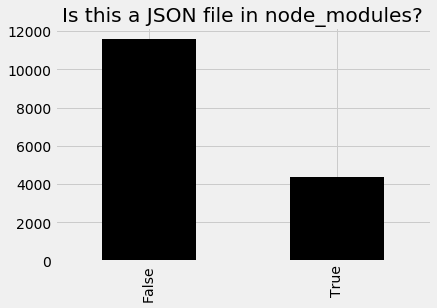

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

df.path.map(lambda p: 'node_modules' in p).value_counts().plot.bar(color='black')
plt.title('Is this a JSON file in node_modules?')

In [18]:
df.path.sample(100).values

array(['okeefem2/rhodesiderelics/tree/master/frontend/node_modules/caniuse-db/features-json/screen-orientation.json',
       'umraniyeacil/umraniyeacil.github.io/tree/master/node_modules/grunt-sass/node_modules/node-sass/node_modules/chalk/node_modules/strip-ansi/package.json',
       'wbg-bigdata/projectratingsml/tree/master/data/txt/P105092/0000A8056_2010082916001786.json',
       'maratonato/slides/tree/master/treinamento1/node_modules/isexe/package.json',
       'yvasiyarov/gorelic/tree/master/nut.json',
       'dakshshah96/cdnjs/tree/master/ajax/libs/oojs-ui/0.22.0/i18n/en-ca.json',
       'mtnguyenvn/zend/tree/master/vendor/zendframework/zend-mail/composer.json',
       'fiftywalrus/SmoothOperator/tree/master/Java 1.6/assets/minecraft/models/block/trapdoor_top_open.json',
       'parasaro92/psd2html/tree/master/node_modules/grunt-http-server/node_modules/http-server/node_modules/union/package.json',
       'cdroescher/OpenRefine-TimeBench-Extension/tree/master/module/bower_compon

## Cleaning

The only cleaning we will do is dropping paths with `node_modules` in them from consideration. These are accidental check-ins of your `node_modules` directory, which you shouldn't be checking in.

In [7]:
df_filtered = df[df.path.map(lambda p: 'node_modules' not in p)]

## Reading sample files

In [47]:
import requests
ex = requests.get('https://github.com/' + df_filtered.sample().raw.values[0])

In [48]:
print(ex.text)

{
    "name":    "phpdocumentor/type-resolver",
    "type":    "library",
    "license": "MIT",
    "authors": [
        {"name": "Mike van Riel", "email": "me@mikevanriel.com"}
    ],
    "require": {
        "php": ">=5.5",
        "phpdocumentor/reflection-common": "^1.0"
    },
    "autoload": {
        "psr-4": {"phpDocumentor\\Reflection\\": ["src/"]}
    },
    "autoload-dev": {
        "psr-4": {"phpDocumentor\\Reflection\\": ["tests/unit"]}
    },
    "require-dev": {
        "phpunit/phpunit": "^5.2||^4.8.24",
        "mockery/mockery": "^0.9.4"
    },
    "extra": {
        "branch-alias": {
            "dev-master": "1.0.x-dev"
        }
    }
}



Compatible JSON strings can be produced by ``to_json()`` with a
corresponding orient value.
The set of possible orients is:

- ``'split'`` : dict like
  ``{index -> [index], columns -> [columns], data -> [values]}``
- ``'records'`` : list like
  ``[{column -> value}, ... , {column -> value}]``
- ``'index'`` : dict like ``{index -> {column -> value}}``
- ``'columns'`` : dict like ``{column -> {index -> value}}``
- ``'values'`` : just the values array

In [120]:
import pandas as pd
from json import JSONDecodeError


def typeof(json_str):
    ret = []
    for orient in ['split', 'records', 'index', 'columns', 'values']:
        try:
            pd.read_json(json_str, orient=orient)
        except:
            pass
        else:
            ret.append(orient)
            
    if not ret:
        ret.append('tree')
        
    return ret


@ratelim.patient(5, 5)
def fetch_random_json():
    return requests.get('https://github.com/' + df_filtered.sample(1).raw.values[0]).text


def sample_json_readable_fmts():
    import json
    
    rand = fetch_random_json()
    try:
        return json.loads(rand), typeof(rand)
    except JSONDecodeError:
        return [None, ['malformed']]

In [123]:
rand_jsons = []
rand_json_fmts_l = []

from tqdm import tqdm_notebook

for _ in tqdm_notebook(list(range(1000))):
    rand_json, rand_json_fmts = sample_json_readable_fmts()
    rand_jsons.append(rand_json)
    rand_json_fmts_l.append(rand_json_fmts)

In [134]:
pd.Series([' '.join(fmt) for fmt in rand_json_fmts_l]).value_counts()

records index columns values          457
tree                                  420
malformed                             121
split records index columns values      2
dtype: int64

## Conclusion

Well, that was profoundly uninteresting!